In [108]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
import torchvision as tv

import os, sys
import numpy as np
import pickle
from PIL import Image
import cv2

import math
from tqdm import tqdm
from misc.losses import sent_loss, words_loss, words_triplet_loss

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances

from model import TextEncoder, ImageEncoder
from transformers import BertConfig

from misc.config import Config
cfg  = Config()
cfg.GPU_ID = 0

torch.cuda.set_device(cfg.GPU_ID)

In [3]:
MAX_DIM = 2048

train_transform = tv.transforms.Compose([
    tv.transforms.RandomRotation(15), # rotation will cost 0.1s for each 10 images
    tv.transforms.RandomCrop(MAX_DIM, pad_if_needed=True), # 0.6s for each 10 images
    tv.transforms.ColorJitter(brightness=[0.5, 1.8] # colorjitter will cost 0.32s for each 10 images
                              , contrast=[0.5, 1.8]
                              , saturation=[0.5, 1.8]),
    tv.transforms.ToTensor(), 
    tv.transforms.Normalize(0.5, 0.5)
])

val_transform = tv.transforms.Compose([
    tv.transforms.CenterCrop(MAX_DIM),
    tv.transforms.ToTensor(),  
    tv.transforms.Normalize(0.5, 0.5)
])

class MimicDataset(Dataset):
    def __init__(self, root, dataset, max_length, transform=val_transform, mode='test'):
        super().__init__()
        
        self.root = root #save dir
        self.transform = transform
        self.mode = mode
#         vocab='allenai/scibert_scivocab_uncased'
#         self.tokenizer = BertTokenizer.from_pretrained(vocab, do_lower=True)

        self.datadict = dataset['data_dict'] # uid: {text:text, filenames:[filename]}
        if self.mode == 'train':
            self.keys = dataset['data_split']['train_uids'] # uid list
        elif self.mode == 'val':
            self.keys = dataset['data_split']['val_uids'] # uid list
        elif self.mode == 'test':
            self.keys = dataset['data_split']['test_uids'] # uid list
        
        self.idx2word = dataset['idx2word']
        self.word2ids = dataset['word2idx']
        self.__sep_id__ = dataset['word2idx']['[SEP]']
        self.vocab_size = len(dataset['word2idx'])
        self.max_length = max_length + 1
        
#         self.err_log = os.path.join(log_dir, 'err.log') # create error log
#         if not os.path.exists(self.err_log):
#             with open(self.err_log, 'w') as f:
#                 f.write('Epoch 0:\n\n')

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        uid = self.keys[idx]
        
        image_id = np.random.choice(self.datadict[uid]['filenames'])# get one file name randomly
        image_path = os.path.join(self.root, image_id.replace('dcm','jpg')) #original used 'jpg', try 'png'

        try:
            with Image.open(image_path) as img: 
                if self.transform:
                    image = self.transform(img)

        except Exception as ex:
#             with open(self.err_log, 'a+') as f:
#                 f.write('%s\nERR_IMG %s\n' % (ex, image_path))
            print(ex)
            print(image_path)
            return None ## return None, collate_fn will ignore this broken sample
        
        max_len_array = np.zeros(self.max_length, dtype='int')
        cap_mask = np.zeros(self.max_length, dtype='int')
        caption = np.array(self.datadict[uid]['token_ids'])
        if len(caption)<=self.max_length:
            cap_mask[:len(caption)] = 1
            max_len_array[:len(caption)] = caption
        else:
            cap_mask[:] = 1
            max_len_array = caption[:self.max_length]
            max_len_array[-1] = self.__sep_id__
        caption = max_len_array
        cap_mask = cap_mask.astype(bool)
        cap_lens = cap_mask.sum(-1)
        return image, caption, cap_mask, uid, cap_lens
    
def build_dataset(mode='test', cfg=None, out_dir=None):
    data_dir = cfg.dataset_root
    img_dir = os.path.join(data_dir, 'physionet.org/files/', 'mimic-cxr-jpg/2.0.0/')
    with open(os.path.join(data_dir,'lm_reports/mimic_dataset_mit_normalized.pkl'),'rb') as f:
        dataset = pickle.load(f)
    if mode == 'train':
        data = MimicDataset(img_dir, dataset, 
                               max_length=cfg.max_length, mode=mode, 
                               transform=train_transform)
        return data

    elif mode == 'val':
        data = MimicDataset(img_dir, dataset, 
                               max_length=cfg.max_length, mode=mode, 
                               transform=val_transform)
        return data
    
    elif mode == 'test':
        data = MimicDataset(img_dir, dataset, 
                               max_length=cfg.max_length, mode=mode, 
                               transform=val_transform)
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")
        
## collate_fn for handling None type item due to image corruption ##
## This will return batch size - broken image number ##
def collate_fn_ignore_none(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [37]:
test_set = build_dataset('val', cfg)
print('Testing set %d is loaded.' % len(test_set))
test_loader = torch.utils.data.DataLoader(
                test_set, batch_size=8, 
                collate_fn=collate_fn_ignore_none, drop_last=False,
                shuffle=True, num_workers=4, pin_memory=False)
print('Vocab size is %d.' % test_set.vocab_size)

Testing set 2000 is loaded.
Vocab size is 8410.


In [74]:
bert_config = BertConfig(vocab_size=test_loader.dataset.vocab_size, hidden_size=512, num_hidden_layers=3,
                    num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
                    hidden_dropout_prob=cfg.hidden_dropout_prob, attention_probs_dropout_prob=cfg.attention_probs_dropout_prob,
                    max_position_embeddings=512, layer_norm_eps=1e-12,
                    initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

##### change the checkpoint path here #####
cfg.text_encoder_path = '/media/My1TBSSD1/IPMI2021/output/MIMIC_damsm_triplet_2020_12_09_09_28_40/Model/text_encoder28.pth'
# ################### encoders ################################# #      
image_encoder = ImageEncoder(output_channels=cfg.hidden_dim)
text_encoder = TextEncoder(bert_config=bert_config, output_channels=cfg.hidden_dim)

if cfg.CUDA:
    text_encoder = text_encoder.cuda()
    image_encoder = image_encoder.cuda()
    
if cfg.text_encoder_path != '':
    img_encoder_path = cfg.text_encoder_path.replace('text_encoder', 'image_encoder')
    print('Load image encoder checkpoint from:', img_encoder_path)
    state_dict = torch.load(img_encoder_path, map_location='cpu')
    image_encoder.load_state_dict(state_dict['model'])

    text_encoder_path = cfg.text_encoder_path
    print('Load text encoder checkpoint from:', text_encoder_path)
    state_dict = torch.load(text_encoder_path, map_location='cpu')
    text_encoder.load_state_dict(state_dict['model'])

Load image encoder checkpoint from: /media/My1TBSSD1/IPMI2021/output/MIMIC_damsm_triplet_2020_12_09_09_28_40/Model/image_encoder28.pth
Load text encoder checkpoint from: /media/My1TBSSD1/IPMI2021/output/MIMIC_damsm_triplet_2020_12_09_09_28_40/Model/text_encoder28.pth


In [91]:
data_iter = iter(test_loader)

imgs, captions, masks, class_ids, cap_lens = data_iter.next()


if cfg.CUDA:
    imgs, captions, masks, cap_lens = imgs.cuda(), captions.cuda(), masks.cuda(), cap_lens.cuda()
     

class_ids = class_ids.numpy()

labels = torch.LongTensor(range(test_loader.batch_size)) # used for matching loss
        
if cfg.CUDA:
    labels = labels.cuda()

ids = np.array(list(range(test_loader.batch_size)))
neg_ids = torch.LongTensor([np.random.choice(ids[ids!=x]) for x in ids]) # used for matching loss
                
neg_ids = neg_ids.cuda()
neg_ids

In [97]:
r_feats, v_feats = image_encoder(imgs)
w_feats, s_feats = text_encoder(captions,masks)

loss0, loss1, att_maps = words_loss(r_feats,w_feats[:,:,1:],labels, cap_lens-1, class_ids, test_loader.batch_size)

In [99]:
idx = 0

class_ids[idx]

sent_tokens = np.array([test_loader.dataset.idx2word[x] for x in captions[idx][:masks[idx].sum()].detach().cpu().numpy()])[1:]

' '.join(sent_tokens)

In [103]:
imgs_selected = imgs.detach().cpu().numpy()

imgs_selected = (imgs_selected[idx][0]+1)/2
imgs_selected.min(),imgs_selected.max()

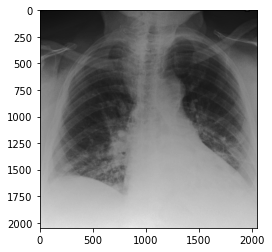

In [106]:
plt.imshow(imgs_selected,cmap='gray')

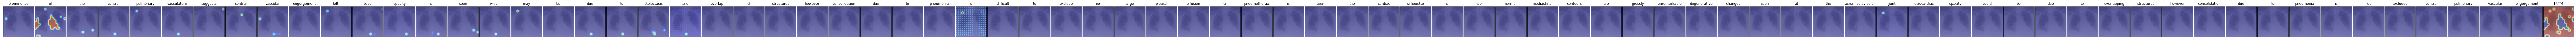

In [107]:
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

maps = att_maps[idx][0].detach().cpu().numpy()


w=10
h=10
fig=plt.figure(figsize=(2*maps.shape[0],2))

columns = maps.shape[0]
rows = 1
ax = []
for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(sent_tokens[i])  # set title
    plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
    plt.imshow(cv2.resize(maps[i],(2048,2048), cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
# for i in range(1, columns*rows +1):
# #     print(i)
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
#     plt.imshow(cv2.resize(maps[i-1],(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
#     ax[-1].set_title(sent_tokens[i-1])
# #     plt.show()
plt.show()

In [ ]:
@torch.no_grad()
def save_img_results(self, imgs, attention_maps):
    # Save images
    for i in range(len(attention_maps)):
        if len(imgs) > 1:
            img = imgs[i + 1].detach().cpu()
            lr_img = imgs[i].detach().cpu()
        else:
            img = imgs[0].detach().cpu()
            lr_img = None
        attn_maps = attention_maps[i]
        att_sze = attn_maps.size(2)
        img_set, _ = \
            build_super_images(img, captions, self.ixtoword,
                               attn_maps, att_sze, lr_imgs=lr_img, batch_size = self.batch_size)
        if img_set is not None:
            im = Image.fromarray(img_set)
            fullpath = '%s/G_%s_%d_%d.png'\
                % ('Image', name, gen_iterations, i)
            im.save(fullpath)

#     # for i in range(len(netsD)):
#     i = -1
#     img = fake_imgs[i].detach()
#     region_features, _ = image_encoder(img)
#     att_sze = region_features.size(2)
#     _, _, att_maps = words_loss(region_features.detach(),
#                                 words_embs.detach(),
#                                 None, cap_lens,
#                                 None, self.batch_size)
#     img_set, _ = \
#         build_super_images(fake_imgs[i].detach().cpu(),
#                            captions, self.ixtoword, att_maps, att_sze, batch_size = self.batch_size)
#     if img_set is not None:
#         im = Image.fromarray(img_set)
#         fullpath = '%s/D_%s_%d.png'\
#             % (self.image_dir, name, gen_iterations)
#         im.save(fullpath)

In [13]:
@torch.no_grad()
def testing(cnn_model, trx_model, dataloader):
    cnn_model.eval()
    trx_model.eval()
    #####################################
    val_data_iter = iter(dataloader)
    
    for step in tqdm(range(len(val_data_iter))):
        
        real_imgs, captions, masks, class_ids, cap_lens = val_data_iter.next()
        class_ids = class_ids.numpy()
        batch_size = real_imgs.shape[0]
        labels = torch.LongTensor(range(batch_size)) # used for matching loss
        if cfg.CUDA:
            real_imgs, captions, masks, cap_lens = real_imgs.cuda(), captions.cuda(), masks.cuda(), cap_lens.cuda()
            labels = labels.cuda()
        words_features, sent_code = cnn_model(real_imgs)
        words_embs, sent_emb = trx_model(captions, masks)
        w_loss0, w_loss1, attn_map = words_loss(words_features, words_embs[:,:,1:], labels,
                                                cap_lens-1, class_ids, batch_size)
        break
    
    return real_imgs, attn_map

In [14]:
imgs, attn_maps = testing(image_encoder, text_encoder, test_loader)

  0%|          | 0/4346 [00:06<?, ?it/s]
